In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, make_scorer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Функции 

In [2]:
# преобразывывает datetime в отдельные признаки и удаляет исходный. Вовзвращает преобразованный df

def date_update(df):
    df['datetime'] = pd.to_datetime(df['datetime']) 
    df['day'] = df.datetime.dt.day
    df['month'] = df.datetime.dt.month
    df['year'] = df.datetime.dt.year
    df['hour'] = df.datetime.dt.hour
    df['day_of_week'] = df.datetime.dt.dayofweek
    df['week_of_year'] = df.datetime.dt.weekofyear
    df = df.drop('datetime', axis=1)
    
    return df

In [3]:
# ф-яя для onehotencoding через get_dummies

def onehotencoding(df, categories):
    for categor in categories:
        df = pd.concat([df, pd.get_dummies(df[categor], prefix=categor)], axis=1)
        
    return df.drop(categories, axis=1)

In [4]:
# ф-яя принимает датасет для обучения и прогнозы. Возвращает pd.Series с прогнозом. Также записывает в файл.

def make_submission(x, y, x_pred):
    
    gbr = GradientBoostingRegressor(alpha=0.99, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='huber', max_depth=5,
                          max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=6,
                          min_weight_fraction_leaf=0.0, n_estimators=800,
                          n_iter_no_change=None, presort='auto',
                          subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
    gbr.fit(x, np.log1p(y))
    predict = gbr.predict(x_pred)
    
    submission = pd.DataFrame({
        "datetime": pd.date_range('2012-12-20', '2013-3-19 23', freq='h'),
        "count": [max(0, x) for x in np.round(np.exp(predict))]
    })
    submission.to_csv('bike_predictions_gbr.csv', index=False)
    
    return pd.Series([max(0, x) for x in np.round(np.exp(predict))])

In [5]:
def make_submission_reg_plus_cas(x, y1, y2, x_pred):
    gbr = GradientBoostingRegressor(alpha=0.99, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='huber', max_depth=5,
                          max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=6,
                          min_weight_fraction_leaf=0.0, n_estimators=800,
                          n_iter_no_change=None, presort='auto',
                          subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
    
    gbr.fit(x, np.log1p(y1))
    predict1 = gbr.predict(x_pred)
    
    gbr.fit(x, np.log1p(y2))
    predict2 = gbr.predict(x_pred)
    
    predict = np.where(np.round(np.exp(predict1))<0, 0, np.round(np.exp(predict1))) + np.where(np.round(np.exp(predict2))<0, 0, np.round(np.exp(predict2)))
    
    submission = pd.DataFrame({
        "datetime": pd.date_range('2012-12-20', '2013-3-19 23', freq='h'),
        "count": [max(0, x) for x in predict]
    })
    submission.to_csv('bike_predictions_gbm_separate_without_fe.csv', index=False)
    
    return pd.Series([max(0, x) for x in predict])

# Обработка датасета для обучения

In [6]:
# читаем данные
x_test = pd.read_csv('test.csv') 
x_train = pd.read_csv('train.csv') 

In [7]:
# преобразовываем дату и время в отдельные признаки

x_train = date_update(x_train)
x_test = date_update(x_test)

In [8]:
# отдельно сохраняем целевые признаки и удаляем из обучающего датасета

y_train_reg = x_train['registered']
y_train_cas = x_train['casual']
y_train = x_train['count']
x_train = x_train.drop(['casual', 'registered', 'count'], axis=1)

# Выбор модели

Т.к. данный датасет известный и на кагле есть тестовые данные, то они и использовались для отбора преобразований и выбора модели.
Лучшие результаты были достигнуты (GridSearchCV) с моделью GradientBoostingRegressor и следующими параметрами:
 - GradientBoostingRegressor(alpha=0.99, criterion='friedman_mse', learning_rate=0.1, loss='huber', max_depth=5, max_features='auto', min_samples_split=6, n_estimators=800)
 - Уменьшение ошибки также получилось разбив прогноз casual и registered на отдельные модели. (после просто суммировав)
 - Для прогноза используем логорифм целевой переменной np.log1p(), а обратно восстанавливает np.exp(). Дает существенное уменьшение ошибки.
 - Best Public Score on Kaggle - 0.38948 (метрика - RMSLE).


In [9]:
# с помощью данной ф-ии производили кросс-валидацию модели и подбирали параметры

def check_rmsle_gb(x, y):
    x_t, x_v, y_t, y_v = train_test_split(x, y, test_size=0.2)
    params={'n_estimators':[700],
            'max_depth' : [5],
            'loss' : ['huber'],
            'learning_rate' : [0.1],
            'alpha' : [0.99],
            'max_features':["auto"],
            'min_samples_split' : [6]}
    grid_gb = GridSearchCV(GradientBoostingRegressor(), param_grid=params, cv=5)
    grid_gb.fit(x_t, np.log1p(y_t))
    y_pred = grid_gb.best_estimator_.predict(x_v)
    
    error = np.sqrt(mean_squared_log_error(y_v, np.exp(np.where(y_pred<=0, 0., y_pred))))
    
    print(grid_gb.best_estimator_)
    return error

# Создае датасета для прогноза

In [10]:
# создаем период с 2012-12-20 до 2013-3-19 с шагом в 1 час

x_predict = pd.DataFrame({"datetime": pd.date_range('2012-12-20', '2013-3-19 23', freq='h')})

In [11]:
# добавляем праздники

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
cal.holidays('2012-12-20', '2013-3-19 23')
x_predict['holiday'] = x_predict['datetime'].isin(cal.holidays('2012-12-20', '2013-3-19 23')).map({False : 0, True : 1})

In [12]:
# преобразовываем дату и время в отдельные признаки также, как и данные для обучения

x_predict = date_update(x_predict)

In [13]:
# добавляем признак season

x_predict['season'] = (x_predict['month'] % 12 + 3) // 3

In [14]:
# добавляем признак рабочий день

x_predict['workingday'] = (x_predict['day_of_week']<5).map({False : 0, True : 1}) # 0 - monday

In [15]:
# добавляем признаки - погода, температура, ощущаемая температура, влажность и скорость ветра 
# (считались как средние показатели за 2 года этот же день и час из обучащющей выборки)

x_full = pd.concat([x_train, x_test], ignore_index=True)


def weather(x, y):
   
    a, b, c, d, e = [], [], [], [], []
    
    for i in x.index:
        day = x[x.index == i]['day'].values[0]
        month = x[x.index == i]['month'].values[0]
        hour = x[x.index == i]['hour'].values[0]

        weather = np.round(y[(y.day==day) & (y.month==month) & (y.hour==hour)]['weather'].values.mean())
        temp = y[(y.day==day) & (y.month==month) & (y.hour==hour)]['temp'].values.mean()
        atemp = y[(y.day==day) & (y.month==month) & (y.hour==hour)]['atemp'].values.mean()
        humidity = np.round(y[(y.day==day) & (y.month==month) & (y.hour==hour)]['humidity'].values.mean())
        wind = y[(y.day==day) & (y.month==month) & (y.hour==hour)]['windspeed'].values.mean()
    
        a.append(weather)
        b.append(temp)
        c.append(atemp)
        d.append(humidity)
        e.append(wind)

    
    
    return a, b, c, d, e

a, b, c, d, e = weather(x_predict, x_full)

x_predict['weather'] = a
x_predict['temp'] = b
x_predict['atemp'] = c
x_predict['humidity'] = d
x_predict['windspeed'] = e

# Прогноз и его оценка

In [16]:
# для раздельного предсказания reg и casual

y_predict = make_submission_reg_plus_cas(x_train.drop(['year'], axis=1), y_train_reg, y_train_cas, x_predict.drop(['year'], axis=1))

In [17]:
def create_plot(df1, df2):
    df = pd.concat([df1, df2], ignore_index=True)
    plt.rcParams["figure.figsize"] = (20,8)
    return df.groupby(['year', 'month'])['count'].sum().plot.bar()

In [18]:
x_train['count'] = y_train
x_predict['count'] = y_predict

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


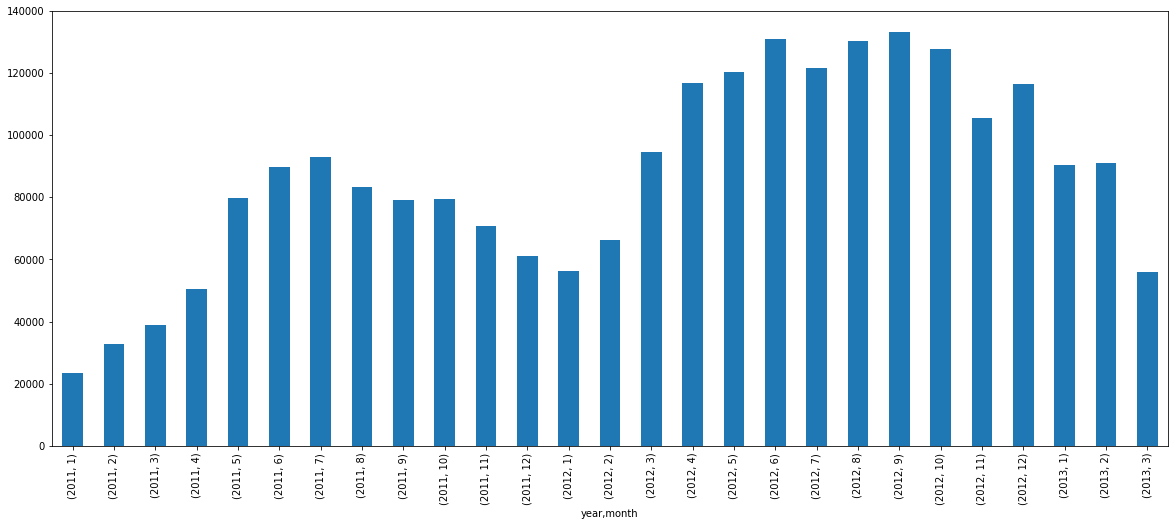

In [19]:
# график суммы целевого признака сгруппированный по месяцам 

create_plot(x_train, x_predict)

# Итог
- Данные из датасета для обучения содержат инфомарцию только за первые 20 дней месяца.
- Если проанализировать график видно, что модель берет примерно средние значение за 2 года(не забываем, что предсказывали ~30 дней, вместо 20 обучающей выборки), что говорит о том, что она не научилась учитывать рост общего количества из года в год.
- Использование OneHotEncoding категориальных признаков незначительно уменьшило ошибку
- Нормализация количественных признаков увеличило ошибку (т.к. в основе бустинга лежат деревья решений)
- Из-за небольшого количества данных погодные условия могли быть спрогнозированы неудачно (подвержены выбросам)
- Предсказание логарифма от целевого признака (вместо фактического его значения) очень значительно повлиял на уменьшение ошибки (RMSLE)
- Библиотека XGBoost не использовалась т.к. не была указана в ТЗ.
- Для прогноза погодных условий использовался также тестовый датасет с кагла


P.S. На кагле в кернелах множество видов EDA анализа и не вижу смысла копировать его сюда.